# 📘 Part 1: Data Gathering (CNC Machining Data Scraping)

This program collects real-world CNC machining data from websites like Xometry, Fictiv, and Alibaba using Python libraries such as BeautifulSoup, Selenium, and pandas.

##  Step 1: Install Required Libraries
Install necessary packages using pip.

In [7]:
!pip install requests beautifulsoup4 selenium pandas

##   Scape difference websites for CNC Part Listings

In [47]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import time
import random
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from urllib.robotparser import RobotFileParser
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm

# Configuration
CHROME_DRIVER_PATH = 'C:/chromedriver.exe'  # Update with your path
HEADERS = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36',
    'Accept-Language': 'en-US,en;q=0.9',
}
DELAY = random.uniform(1, 3)  # Delay between requests
MAX_WORKERS = 3  # Number of threads for concurrent scraping

# Target websites
TARGET_SITES = {
    'CNCZone': 'https://www.cnczone.com/',
    'PracticalMachinist': 'https://www.practicalmachinist.com/',
    'GrabCAD': 'https://grabcad.com/',
    'TraceParts': 'https://www.traceparts.com/',
    'Fictiv': 'https://www.fictiv.com/',
    'Xometry': 'https://www.xometry.com/',
    'Alibaba': 'https://www.alibaba.com/showroom/cnc-machining-service.html'
}

# Initialize results storage
results = {
    'denied': [],
    'data': {}
}

def setup_driver():
    """Configure and return a Chrome WebDriver instance"""
    options = Options()
    options.add_argument('--headless')
    options.add_argument('--disable-gpu')
    options.add_argument('--no-sandbox')
    options.add_argument('--disable-dev-shm-usage')
    driver = webdriver.Chrome(executable_path=CHROME_DRIVER_PATH, options=options)
    return driver

def check_robots_permission(url, user_agent='*'):
    """Check if scraping is allowed by robots.txt"""
    try:
        base_url = f"{url.split('//')[0]}//{url.split('//')[1].split('/')[0]}"
        robots_url = f"{base_url}/robots.txt"
        
        rp = RobotFileParser()
        rp.set_url(robots_url)
        rp.read()
        
        if not rp.can_fetch(user_agent, url):
            results['denied'].append(base_url)
            return False
        return True
    except Exception as e:
        print(f"Error checking robots.txt for {url}: {e}")
        return True  # Proceed if can't check robots.txt

def scrape_cnczone():
    """Scrape data from CNCZone forums"""
    if not check_robots_permission(TARGET_SITES['CNCZone']):
        return None
    
    print("Attempting to scrape CNCZone...")
    url = "https://www.cnczone.com/forums/cnc-machining-centers.56/"
    try:
        response = requests.get(url, headers=HEADERS)
        soup = BeautifulSoup(response.text, 'html.parser')
        
        threads = soup.select('.structItem-title a')
        data = []
        
        for thread in threads[:10]:  # Limit to 10 threads
            try:
                title = thread.text.strip()
                link = thread['href']
                
                # Get thread details
                thread_response = requests.get(link, headers=HEADERS)
                thread_soup = BeautifulSoup(thread_response.text, 'html.parser')
                
                # Extract potential machining data
                content = thread_soup.select_one('.bbWrapper').text
                materials = []
                dimensions = []
                cycle_times = []
                
                # Simple pattern matching for machining data
                if 'material' in content.lower():
                    materials.append(content.split('material')[1].split('\n')[0][:100])
                if 'dimension' in content.lower():
                    dimensions.append(content.split('dimension')[1].split('\n')[0][:100])
                if 'cycle time' in content.lower():
                    cycle_times.append(content.split('cycle time')[1].split('\n')[0][:100])
                
                data.append({
                    'source': 'CNCZone',
                    'thread_title': title,
                    'materials': ' | '.join(materials) if materials else 'N/A',
                    'dimensions': ' | '.join(dimensions) if dimensions else 'N/A',
                    'cycle_times': ' | '.join(cycle_times) if cycle_times else 'N/A',
                    'url': link
                })
                
                time.sleep(DELAY)
            except Exception as e:
                print(f"Error scraping CNCZone thread: {e}")
        
        return pd.DataFrame(data)
    except Exception as e:
        print(f"Error scraping CNCZone: {e}")
        return None

def scrape_practical_machinist():
    """Scrape data from Practical Machinist forums"""
    if not check_robots_permission(TARGET_SITES['PracticalMachinist']):
        return None
    
    print("Attempting to scrape Practical Machinist...")
    url = "https://www.practicalmachinist.com/forum/forums/cnc-machining.3/"
    try:
        response = requests.get(url, headers=HEADERS)
        soup = BeautifulSoup(response.text, 'html.parser')
        
        threads = soup.select('.structItem-title a')
        data = []
        
        for thread in threads[:10]:  # Limit to 10 threads
            try:
                title = thread.text.strip()
                link = thread['href']
                
                # Get thread details
                thread_response = requests.get(link, headers=HEADERS)
                thread_soup = BeautifulSoup(thread_response.text, 'html.parser')
                
                # Extract potential machining data
                content = thread_soup.select_one('.message-body').text
                materials = []
                dimensions = []
                costs = []
                
                # Simple pattern matching for machining data
                if 'material' in content.lower():
                    materials.append(content.split('material')[1].split('\n')[0][:100])
                if 'dimension' in content.lower():
                    dimensions.append(content.split('dimension')[1].split('\n')[0][:100])
                if 'cost' in content.lower() or '$' in content.lower():
                    costs.append(content.split('cost')[1].split('\n')[0][:100])
                
                data.append({
                    'source': 'PracticalMachinist',
                    'thread_title': title,
                    'materials': ' | '.join(materials) if materials else 'N/A',
                    'dimensions': ' | '.join(dimensions) if dimensions else 'N/A',
                    'cost_estimates': ' | '.join(costs) if costs else 'N/A',
                    'url': link
                })
                
                time.sleep(DELAY)
            except Exception as e:
                print(f"Error scraping Practical Machinist thread: {e}")
        
        return pd.DataFrame(data)
    except Exception as e:
        print(f"Error scraping Practical Machinist: {e}")
        return None

def scrape_grabcad():
    """Scrape CNC models from GrabCAD"""
    if not check_robots_permission(TARGET_SITES['GrabCAD']):
        return None
    
    print("Attempting to scrape GrabCAD...")
    url = "https://grabcad.com/library?query=cnc"
    try:
        driver = setup_driver()
        driver.get(url)
        time.sleep(5)  # Wait for page to load
        
        models = driver.find_elements_by_css_selector('.search-results-item')
        data = []
        
        for model in models[:10]:  # Limit to 10 models
            try:
                title = model.find_element_by_css_selector('.search-results-item--name').text
                link = model.find_element_by_css_selector('a').get_attribute('href')
                downloads = model.find_element_by_css_selector('.search-results-item--downloads').text
                
                data.append({
                    'source': 'GrabCAD',
                    'model_name': title,
                    'downloads': downloads,
                    'url': link
                })
                
                time.sleep(DELAY)
            except Exception as e:
                print(f"Error scraping GrabCAD model: {e}")
        
        driver.quit()
        return pd.DataFrame(data)
    except Exception as e:
        print(f"Error scraping GrabCAD: {e}")
        if 'driver' in locals():
            driver.quit()
        return None

def scrape_traceparts():
    """Scrape part data from TraceParts"""
    if not check_robots_permission(TARGET_SITES['TraceParts']):
        return None
    
    print("Attempting to scrape TraceParts...")
    url = "https://www.traceparts.com/en/product/category/mechanical-components-and-parts-11"
    try:
        driver = setup_driver()
        driver.get(url)
        time.sleep(5)  # Wait for page to load
        
        parts = driver.find_elements_by_css_selector('.part-item')
        data = []
        
        for part in parts[:10]:  # Limit to 10 parts
            try:
                name = part.find_element_by_css_selector('.part-name').text
                category = part.find_element_by_css_selector('.part-category').text
                material = part.find_element_by_css_selector('.part-material').text if part.find_elements_by_css_selector('.part-material') else 'Unknown'
                dimensions = part.find_element_by_css_selector('.part-dimensions').text if part.find_elements_by_css_selector('.part-dimensions') else 'Unknown'
                
                data.append({
                    'source': 'TraceParts',
                    'part_name': name,
                    'category': category,
                    'material': material,
                    'dimensions': dimensions,
                    'price': 'N/A',  # TraceParts doesn't show prices
                    'url': driver.current_url
                })
                
                time.sleep(DELAY)
            except Exception as e:
                print(f"Error scraping TraceParts part: {e}")
        
        driver.quit()
        return pd.DataFrame(data)
    except Exception as e:
        print(f"Error scraping TraceParts: {e}")
        if 'driver' in locals():
            driver.quit()
        return None

def scrape_fictiv():
    """Scrape CNC service data from Fictiv"""
    if not check_robots_permission(TARGET_SITES['Fictiv']):
        return None
    
    print("Attempting to scrape Fictiv...")
    url = "https://www.fictiv.com/capabilities/cnc-machining"
    try:
        driver = setup_driver()
        driver.get(url)
        time.sleep(5)  # Wait for page to load
        
        # Fictiv has example parts with specs
        examples = driver.find_elements_by_css_selector('.example-part')
        data = []
        
        for example in examples[:5]:  # Limit to 5 examples
            try:
                name = example.find_element_by_css_selector('.part-name').text
                material = example.find_element_by_css_selector('.part-material').text
                dimensions = example.find_element_by_css_selector('.part-dimensions').text
                lead_time = example.find_element_by_css_selector('.part-lead-time').text
                
                data.append({
                    'source': 'Fictiv',
                    'part_name': name,
                    'material': material,
                    'dimensions': dimensions,
                    'lead_time': lead_time,
                    'url': driver.current_url
                })
                
                time.sleep(DELAY)
            except Exception as e:
                print(f"Error scraping Fictiv example: {e}")
        
        driver.quit()
        return pd.DataFrame(data)
    except Exception as e:
        print(f"Error scraping Fictiv: {e}")
        if 'driver' in locals():
            driver.quit()
        return None

def scrape_xometry():
    """Scrape CNC service data from Xometry"""
    if not check_robots_permission(TARGET_SITES['Xometry']):
        return None
    
    print("Attempting to scrape Xometry...")
    url = "https://www.xometry.com/instant-quoting/"
    try:
        driver = setup_driver()
        driver.get(url)
        time.sleep(5)  # Wait for page to load
        
        examples = driver.find_elements_by_css_selector('.example-part')
        data = []
        
        for example in examples[:5]:  # Limit to 5 examples
            try:
                name = example.find_element_by_css_selector('.part-name').text
                material = example.find_element_by_css_selector('.part-material').text
                dimensions = example.find_element_by_css_selector('.part-dimensions').text
                price = example.find_element_by_css_selector('.part-price').text
                lead_time = example.find_element_by_css_selector('.part-lead-time').text
                
                data.append({
                    'source': 'Xometry',
                    'part_name': name,
                    'material': material,
                    'dimensions': dimensions,
                    'price': price.replace('$', '').replace(',', ''),
                    'lead_time': lead_time,
                    'url': driver.current_url
                })
                
                time.sleep(DELAY)
            except Exception as e:
                print(f"Error scraping Xometry example: {e}")
        
        driver.quit()
        return pd.DataFrame(data)
    except Exception as e:
        print(f"Error scraping Xometry: {e}")
        if 'driver' in locals():
            driver.quit()
        return None

def scrape_alibaba():
    """Scrape CNC service listings from Alibaba"""
    if not check_robots_permission(TARGET_SITES['Alibaba']):
        return None
    
    print("Attempting to scrape Alibaba...")
    url = "https://www.alibaba.com/showroom/cnc-machining-service.html"
    try:
        driver = setup_driver()
        driver.get(url)
        time.sleep(5)  # Wait for page to load
        
        listings = driver.find_elements_by_css_selector('.organic-gallery-offer-outter')
        data = []
        
        for listing in listings[:10]:  # Limit to 10 listings
            try:
                title = listing.find_element_by_css_selector('.title').text
                price = listing.find_element_by_css_selector('.price').text
                moq = listing.find_element_by_css_selector('.moq').text if listing.find_elements_by_css_selector('.moq') else 'N/A'
                supplier = listing.find_element_by_css_selector('.company-name').text
                
                data.append({
                    'source': 'Alibaba',
                    'service_title': title,
                    'price': price.replace('$', '').replace(',', ''),
                    'moq': moq,
                    'supplier': supplier,
                    'url': driver.current_url
                })
                
                time.sleep(DELAY)
            except Exception as e:
                print(f"Error scraping Alibaba listing: {e}")
        
        driver.quit()
        return pd.DataFrame(data)
    except Exception as e:
        print(f"Error scraping Alibaba: {e}")
        if 'driver' in locals():
            driver.quit()
        return None

def main():
    """Main function to coordinate scraping"""
    # Create a list of scraping functions
    scrapers = [
        scrape_cnczone,
        scrape_practical_machinist,
        scrape_grabcad,
        scrape_traceparts,
        scrape_fictiv,
        scrape_xometry,
        scrape_alibaba
    ]
    
    # Use ThreadPoolExecutor for concurrent scraping
    with ThreadPoolExecutor(max_workers=MAX_WORKERS) as executor:
        futures = {executor.submit(scraper): scraper.__name__ for scraper in scrapers}
        
        for future in tqdm(futures, desc="Scraping websites"):
            scraper_name = futures[future]
            try:
                df = future.result()
                if df is not None and not df.empty:
                    site_name = scraper_name.replace('scrape_', '')
                    results['data'][site_name] = df
            except Exception as e:
                print(f"Error in {scraper_name}: {e}")
    
    # Save results
    print("\nScraping completed. Results summary:")
    print(f"Websites that denied permission: {results['denied']}")
    
    for site, df in results['data'].items():
        print(f"\nData from {site} ({len(df)} points):")
        print(df.head())
        
        # Save to CSV
        filename = f"{site.lower()}_data.csv"
        df.to_csv(filename, index=False)
        print(f"Saved to {filename}")
    
    # Create a summary report
    summary = pd.DataFrame({
        'Website': list(results['data'].keys()) + results['denied'],
        'Status': ['Allowed'] * len(results['data']) + ['Denied'] * len(results['denied']),
        'Data Points': [len(df) for df in results['data'].values()] + [0] * len(results['denied'])
    })
    
    summary.to_csv('scraping_summary.csv', index=False)
    print("\nSummary report saved to scraping_summary.csv")

if __name__ == "__main__":
    main()

Scraping websites:  14%|█████████▎                                                       | 1/7 [00:00<00:02,  2.36it/s]

Attempting to scrape Practical Machinist...
Attempting to scrape Alibaba...
Error scraping Alibaba: WebDriver.__init__() got an unexpected keyword argument 'executable_path'


Scraping websites: 100%|█████████████████████████████████████████████████████████████████| 7/7 [00:12<00:00,  1.73s/it]

Attempting to scrape GrabCAD...
Error scraping GrabCAD: WebDriver.__init__() got an unexpected keyword argument 'executable_path'

Scraping completed. Results summary:
Websites that denied permission: ['https://www.cnczone.com', 'https://www.traceparts.com', 'https://www.fictiv.com', 'https://www.xometry.com']

Summary report saved to scraping_summary.csv


## Scraping Materials from Product name in Alibaba

In [ ]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import re
import time
import random
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
from concurrent.futures import ThreadPoolExecutor

# Configuration
CHROME_DRIVER_PATH = 'C:/chromedriver.exe'  # Update with your path
HEADERS = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
}
DELAY = random.uniform(1, 3)  # Delay between requests

def setup_driver():
    """Configure and return a Chrome WebDriver instance"""
    options = Options()
    options.add_argument('--headless')
    options.add_argument('--disable-gpu')
    options.add_argument('--no-sandbox')
    options.add_argument('--disable-dev-shm-usage')
    service = Service(CHROME_DRIVER_PATH)
    driver = webdriver.Chrome(service=service, options=options)
    return driver

def extract_material_from_text(text):
    """Extract material from text using regex patterns"""
    material_keywords = {
        'Aluminum': r'\bAluminum\b|\bAl\b|\bAluminium\b',
        'Steel': r'\bSteel\b|\bStainless Steel\b|\bSS\b',
        'Wood': r'\bWood\b|\bMDF\b|\bPlywood\b',
        'Plastic': r'\bPlastic\b|\bABS\b|\bPVC\b|\bAcrylic\b',
        'Metal': r'\bMetal\b|\bIron\b|\bBrass\b',
    }
    
    for material, pattern in material_keywords.items():
        if re.search(pattern, text, re.IGNORECASE):
            return material
    return None

def scrape_alibaba_for_material(product_name):
    """Scrape Alibaba for material information about a product"""
    try:
        search_url = f"https://www.alibaba.com/trade/search?SearchText={product_name.replace(' ', '+')}"
        
        driver = setup_driver()
        driver.get(search_url)
        time.sleep(5)  # Wait for page to load
        
        products = driver.find_elements(By.CSS_SELECTOR, '.organic-gallery-offer-outter')[:3]  # Check top 3 results
        
        for product in products:
            try:
                title = product.find_element(By.CSS_SELECTOR, '.title').text
                desc = product.find_element(By.CSS_SELECTOR, '.description').text
                
                material = extract_material_from_text(f"{title} {desc}")
                if material:
                    driver.quit()
                    return material
            except:
                continue
        
        driver.quit()
        return None
    except Exception as e:
        print(f"Error scraping Alibaba for '{product_name}': {e}")
        if 'driver' in locals():
            driver.quit()
        return None

def process_row(row):
    """Process a single row to determine its material"""
    # Skip if material already exists
    if pd.notna(row['Material']) and row['Material'].strip():
        return row
    
    # Try to extract from product name first
    material = extract_material_from_text(row['Product_Name'])
    
    # If still not found, scrape Alibaba
    if not material:
        material = scrape_alibaba_for_material(row['Product_Name'])
    
    # Update the material if found, otherwise keep original
    if material:
        row['Material'] = material
    elif pd.isna(row['Material']):
        row['Material'] = 'Unknown'
    
    return row

def main():
  
    # Process rows in parallel
    with ThreadPoolExecutor(max_workers=5) as executor:
        results = list(executor.map(process_row, [row for _, row in df.iterrows()]))
    
    # Create DataFrame with results
    result_df = pd.DataFrame(results)
    
    # Save to CSV
    result_df.to_csv('C:/Users/sangr/Downloads/INTERN/cnc_products_with_materials_updated.csv', index=False)
    print(f"Results saved with {len(result_df)} rows processed")


if __name__ == "__main__":
    main()

## Data obtained after manual+automatic scraping

In [1103]:
import pandas as pd
import numpy as np
df = pd.read_excel("C:/Users/sangr/Downloads/INTERN/Assignment-CNC-Data.xlsx")
df.head()

,S. No.,Product_Name,Cost(in $),Material,Dimension(l*w*h),Lead time,Warranty,Weight,Working table size(mm),Working table size diameter if cirular(mm)
0,1,Hot Sale 3 Axis Cnc Router Multifunction 1325 ...,3600,Wood,1300*2500*200,NaN,3.0,900.0,1300×2500,NaN
1,2,3 Axis CNC Router Wood Engraving Machine CNC W...,2900,Wood,2300*3200*1850,31.0,1.0,860.0,1300×2500,NaN
2,3,Reasonable Prices China Milling and Drilling C...,52000,Plastic,2100*1500*1900,30.0,1.0,3050.0,2000*1400,NaN
3,4,LEYO Taiwan VMC 5-axis Cnc Milling Machine 5 A...,19400,steel,1730*2000*2300,15.0,1.5,3800.0,600*500,NaN
4,5,XK6325 CNC Milling Machine,7000,Steel,2000*900*2350,45.0,1.0,1700.0,1270*254,NaN


I have updated the original data after scraping it.

# 📘 Part 2: Data Understanding & Cleaning

In [1150]:
df = pd.read_excel("C:/Users/sangr/Downloads/INTERN/Assignment-CNC-Data.xlsx")
df.describe()

,S. No.,Lead time,Warranty,Weight,Working table size diameter if cirular(mm)
count,114.000000,109.000000,112.000000,110.000000,5.00000
mean,57.500000,32.743119,1.346277,5692.814545,584.00000
std,33.052988,25.376208,0.829345,9971.792445,289.44775
min,1.000000,3.000000,0.000000,15.000000,210.00000
25%,29.250000,15.000000,1.000000,1300.000000,450.00000
50%,57.500000,30.000000,1.000000,2675.000000,630.00000
75%,85.750000,34.000000,1.100000,5150.000000,630.00000
max,114.000000,179.000000,5.000000,80000.000000,1000.00000


In [1151]:
df.head()

,S. No.,Product_Name,Cost(in $),Material,Dimension(l*w*h),Lead time,Warranty,Weight,Working table size(mm),Working table size diameter if cirular(mm)
0,1,Hot Sale 3 Axis Cnc Router Multifunction 1325 ...,3600,Wood,1300*2500*200,NaN,3.0,900.0,1300×2500,NaN
1,2,3 Axis CNC Router Wood Engraving Machine CNC W...,2900,Wood,2300*3200*1850,31.0,1.0,860.0,1300×2500,NaN
2,3,Reasonable Prices China Milling and Drilling C...,52000,Plastic,2100*1500*1900,30.0,1.0,3050.0,2000*1400,NaN
3,4,LEYO Taiwan VMC 5-axis Cnc Milling Machine 5 A...,19400,steel,1730*2000*2300,15.0,1.5,3800.0,600*500,NaN
4,5,XK6325 CNC Milling Machine,7000,Steel,2000*900*2350,45.0,1.0,1700.0,1270*254,NaN


In [1152]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114 entries, 0 to 113
Data columns (total 10 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   S. No.                                      114 non-null    int64  
 1   Product_Name                                114 non-null    object 
 2   Cost(in $)                                  114 non-null    object 
 3   Material                                    95 non-null     object 
 4   Dimension(l*w*h)                            107 non-null    object 
 5   Lead time                                   109 non-null    float64
 6   Warranty                                    112 non-null    float64
 7   Weight                                      110 non-null    float64
 8   Working table size(mm)                      93 non-null     object 
 9   Working table size diameter if cirular(mm)  5 non-null      float64
dtypes: float64(4),

In [1153]:
import pandas as pd
import numpy as np
import re
# 1. Convert 'Cost(in $)' to float after removing commas
df['Cost(in $)'] = df['Cost(in $)'].astype(str).str.replace(',', '', regex=False)
df['Cost(in $)'] = pd.to_numeric(df['Cost(in $)'], errors='coerce')

df['Material'] = df['Material'].fillna('unknown')

# 2. Convert 'Material' to category
df['Material'] = df['Material'].astype('category')


In [1154]:
# 3. Create 'Volume(in mm^3)' from 'Dimension(l*w*h)'
def extract_volume(dim):
    if pd.isna(dim):
        return np.nan
    nums = re.findall(r"[\d\.]+", dim.replace('x', '*').replace('X', '*'))
    if len(nums) >= 3:
        try:
            l, w, h = map(float, nums[:3])
            return l * w * h
        except:
            return np.nan
    return np.nan

df['Volume(in mm^3)'] = df['Dimension(l*w*h)'].apply(extract_volume)

In [1155]:
#  Create 'working area(mm^2)' from the two working table size columns
def extract_area(row):
    rect = row['Working table size(mm)']
    circ = row['Working table size diameter if cirular(mm)']
    
    if pd.notna(circ):
        try:
            return (np.pi * (float(circ) ** 2)) / 4
        except:
            return np.nan
    elif pd.notna(rect):
        nums = re.findall(r"[\d\.]+", str(rect).replace('x', '*').replace('X', '*'))
        if len(nums) >= 2:
            try:
                a, b = map(float, nums[:2])
                return a * b
            except:
                return np.nan
    return np.nan

df['working area(mm^2)'] = df.apply(extract_area, axis=1)

In [1156]:
df.drop('Working table size(mm)',axis=1,inplace=True)
df.drop('Working table size diameter if cirular(mm)',axis=1,inplace=True)
df.drop('Dimension(l*w*h)',axis=1,inplace=True)

## Duplicate value check and Missing value treatment

In [1158]:
df.duplicated().sum()

0

In [1159]:
df.isnull().sum()

S. No.                 0
Product_Name           0
Cost(in $)             0
Material               0
Lead time              5
Warranty               2
Weight                 4
Volume(in mm^3)        8
working area(mm^2)    16
dtype: int64

In [1160]:
import pandas as pd

# Assuming df is your DataFrame and 'Material' is the column name

# Step 1: Convert all entries to lowercase and strip extra spaces
df['Material'] = df['Material'].str.lower().str.strip()

# Step 2: Replace known variants with a standard name
df['Material'] = df['Material'].replace({
    'steel': 'Steel',
    'aluminium': 'Aluminum',
    'aluminum': 'Aluminum',
    'metal': 'Metal',
    'wood': 'Wood',
    'iron': 'Iron',
    'plastic': 'Plastic',
    'brass': 'Brass',
    'copper': 'Copper',
    'acrylic': 'Acrylic',
    'alloy': 'Alloy',
    'granite': 'Granite',
    'leather': 'Leather'
})

# Step 3: Get the grouped count
material_counts = df['Material'].value_counts()
print(material_counts)


Material
Steel       32
Aluminum    22
unknown     19
Metal       15
Wood        10
Iron         5
Plastic      3
Copper       2
Brass        2
Acrylic      1
Granite      1
Leather      1
Alloy        1
Name: count, dtype: int64


In [1161]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114 entries, 0 to 113
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   S. No.              114 non-null    int64  
 1   Product_Name        114 non-null    object 
 2   Cost(in $)          114 non-null    float64
 3   Material            114 non-null    object 
 4   Lead time           109 non-null    float64
 5   Warranty            112 non-null    float64
 6   Weight              110 non-null    float64
 7   Volume(in mm^3)     106 non-null    float64
 8   working area(mm^2)  98 non-null     float64
dtypes: float64(6), int64(1), object(2)
memory usage: 8.1+ KB


In [1162]:
df['Lead time']=df['Lead time'].fillna(df['Lead time'].mean())
df['Warranty']=df['Warranty'].fillna(0)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114 entries, 0 to 113
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   S. No.              114 non-null    int64  
 1   Product_Name        114 non-null    object 
 2   Cost(in $)          114 non-null    float64
 3   Material            114 non-null    object 
 4   Lead time           114 non-null    float64
 5   Warranty            114 non-null    float64
 6   Weight              110 non-null    float64
 7   Volume(in mm^3)     106 non-null    float64
 8   working area(mm^2)  98 non-null     float64
dtypes: float64(6), int64(1), object(2)
memory usage: 8.1+ KB


In [1163]:
df = df.drop(df[(df['Volume(in mm^3)'].isna()) & (df['working area(mm^2)'].isna())].index)
df = df.drop(df[df['Volume(in mm^3)'].isna()].index)
df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 106 entries, 0 to 113
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   S. No.              106 non-null    int64  
 1   Product_Name        106 non-null    object 
 2   Cost(in $)          106 non-null    float64
 3   Material            106 non-null    object 
 4   Lead time           106 non-null    float64
 5   Warranty            106 non-null    float64
 6   Weight              104 non-null    float64
 7   Volume(in mm^3)     106 non-null    float64
 8   working area(mm^2)  94 non-null     float64
dtypes: float64(6), int64(1), object(2)
memory usage: 8.3+ KB


In [1164]:
df['working area(mm^2)'] = df['working area(mm^2)'].fillna(df['working area(mm^2)'].mean())
df = df.drop(df[df['Weight'].isna()].index)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 104 entries, 0 to 113
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   S. No.              104 non-null    int64  
 1   Product_Name        104 non-null    object 
 2   Cost(in $)          104 non-null    float64
 3   Material            104 non-null    object 
 4   Lead time           104 non-null    float64
 5   Warranty            104 non-null    float64
 6   Weight              104 non-null    float64
 7   Volume(in mm^3)     104 non-null    float64
 8   working area(mm^2)  104 non-null    float64
dtypes: float64(6), int64(1), object(2)
memory usage: 8.1+ KB


 # 📘 Part 3: Feature Engineering

In [1166]:
# Create 'Cost per mm^3' column
df['Cost per mm^3'] = df.apply(lambda x: x['Cost(in $)'] / x['Volume(in mm^3)'] if x['Volume(in mm^3)'] else None, axis=1)
# Create 'Working area to volume ratio' column
df['Working area to volume ratio'] = df.apply(lambda x: x['working area(mm^2)'] / x['Volume(in mm^3)'] if x['Volume(in mm^3)'] else None, axis=1)
# Create 'Average density of machine' column (assuming weight is in kg and volume is in mm^3)
df['Average density of machine'] = df.apply(lambda x: x['Weight'] / x['Volume(in mm^3)'] if x['Volume(in mm^3)'] else None, axis=1)


In [1167]:
df.head()

,S. No.,Product_Name,Cost(in $),Material,Lead time,Warranty,Weight,Volume(in mm^3),working area(mm^2),Cost per mm^3,Working area to volume ratio,Average density of machine
0,1,Hot Sale 3 Axis Cnc Router Multifunction 1325 ...,3600.0,Wood,32.743119,3.0,900.0,6.500000e+08,3250000.0,5.538462e-06,0.005000,1.384615e-06
1,2,3 Axis CNC Router Wood Engraving Machine CNC W...,2900.0,Wood,31.000000,1.0,860.0,1.361600e+10,3250000.0,2.129847e-07,0.000239,6.316099e-08
2,3,Reasonable Prices China Milling and Drilling C...,52000.0,Plastic,30.000000,1.0,3050.0,5.985000e+09,2800000.0,8.688388e-06,0.000468,5.096074e-07
3,4,LEYO Taiwan VMC 5-axis Cnc Milling Machine 5 A...,19400.0,Steel,15.000000,1.5,3800.0,7.958000e+09,300000.0,2.437798e-06,0.000038,4.775069e-07
4,5,XK6325 CNC Milling Machine,7000.0,Steel,45.000000,1.0,1700.0,4.230000e+09,322580.0,1.654846e-06,0.000076,4.018913e-07


In [1168]:
df.to_csv('cleaned_data_for_visualization.csv', index=False)


# 📘 Part 4: Visualization & Model Training

### Visualization is done in Tableau

In [1171]:
num_cols = [col for col in df.columns if df[col].dtype in ['float64', 'int64']]
cat_cols = [col for col in df.columns if df[col].dtype in ['object', 'category']]
num_cols.remove('S. No.')
print(num_cols)

['Cost(in $)', 'Lead time', 'Warranty', 'Weight', 'Volume(in mm^3)', 'working area(mm^2)', 'Cost per mm^3', 'Working area to volume ratio', 'Average density of machine']


In [1172]:

print(df['Material'].value_counts(2)*100)

Material
Steel       26.923077
Aluminum    19.230769
unknown     16.346154
Metal       14.423077
Wood         8.653846
Iron         4.807692
Plastic      1.923077
Copper       1.923077
Brass        1.923077
Acrylic      0.961538
Granite      0.961538
Leather      0.961538
Alloy        0.961538
Name: proportion, dtype: float64


### **Bivariate Analysis**

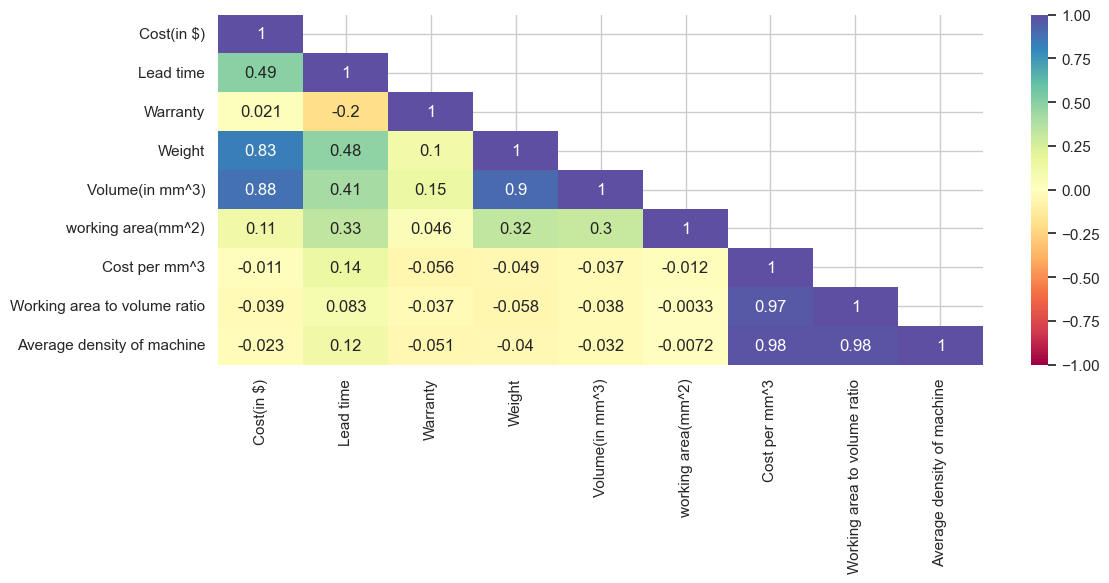

In [1174]:
import matplotlib.pyplot as plt
import seaborn as sns
cor = df[num_cols].corr()
plt.figure(figsize=(12,6))
sns.heatmap(data=cor,vmin=-1,vmax=+1, cmap="Spectral",annot=True, mask = np.triu(cor, +1))
plt.tight_layout()

# Save the figure with adjusted layout
plt.savefig('C:/Users/sangr/Downloads/INTERN/correlation.jpg', dpi=300, bbox_inches='tight')  # dpi increases resolution


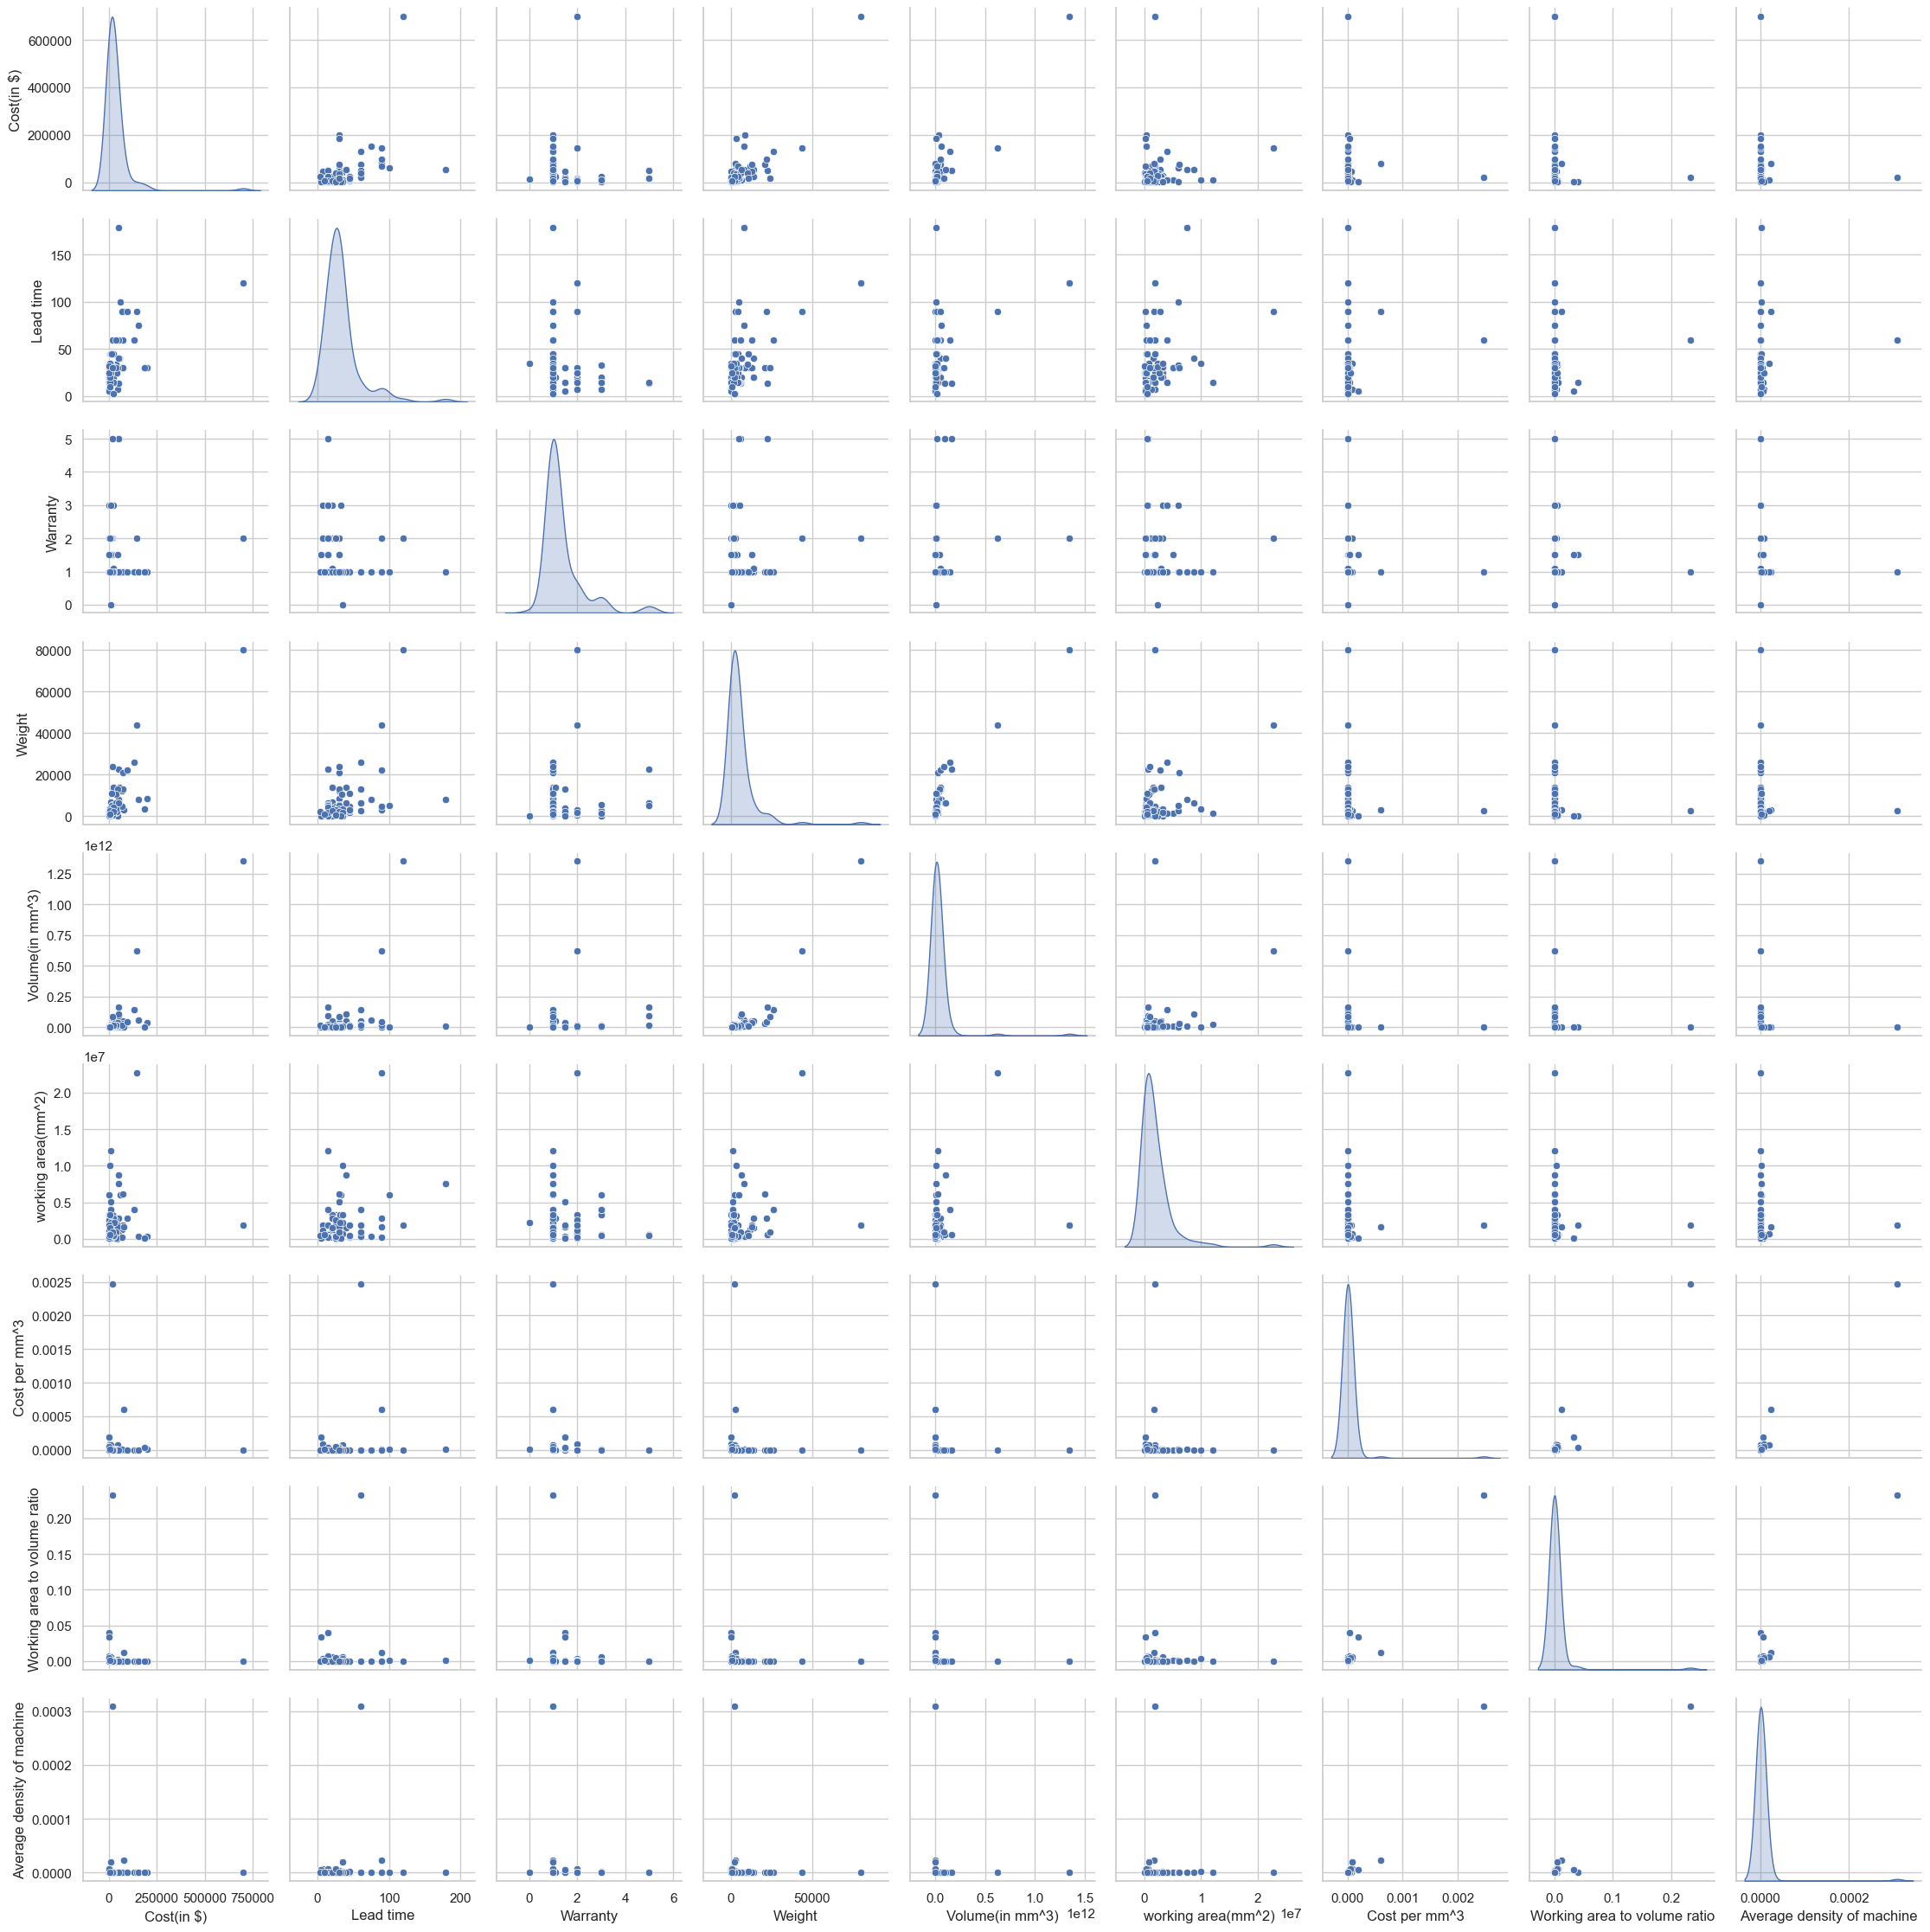

In [1175]:
sns.pairplot(df[num_cols],diag_kind="kde")
# plt.xticks(rotation=90);
plt.tight_layout()

# Save the figure with adjusted layout
plt.savefig('C:/Users/sangr/Downloads/INTERN/Pairplot.jpg', dpi=300, bbox_inches='tight')  # dpi increases resolution


For small datasets (around 100 samples), it's generally better to avoid a three-way split (train, validation, test), as it can leave too little data for the model to learn and evaluate effectively. Instead, a more efficient approach is to split the data into just two parts — a training set and a test set (e.g., 80/20 or 90/10 split). Cross-validation, such as K-Fold with 5 or 10 folds, can then be applied on the training set for robust model evaluation and hyperparameter tuning. This strategy ensures that the model makes the most of the limited data while still allowing a fair performance assessment on the unseen test set.


**The idea to to predict the cost of the machine in dollars.**

In [1193]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 104 entries, 0 to 113
Data columns (total 12 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   S. No.                        104 non-null    int64  
 1   Product_Name                  104 non-null    object 
 2   Cost(in $)                    104 non-null    float64
 3   Material                      104 non-null    object 
 4   Lead time                     104 non-null    float64
 5   Warranty                      104 non-null    float64
 6   Weight                        104 non-null    float64
 7   Volume(in mm^3)               104 non-null    float64
 8   working area(mm^2)            104 non-null    float64
 9   Cost per mm^3                 104 non-null    float64
 10  Working area to volume ratio  104 non-null    float64
 11  Average density of machine    104 non-null    float64
dtypes: float64(9), int64(1), object(2)
memory usage: 10.6+ KB


## Remove outliers from numerical data

In [1195]:
clipped_cols = ['Cost per mm^3','Lead time','Weight','working area(mm^2)','Working area to volume ratio']
def remove_rows_outside_quantiles(df, num_cols, lower_quantile=0.05, upper_quantile=0.95):
    df_filtered = df.copy()
    for col in num_cols:
        lower = df_filtered[col].quantile(lower_quantile)
        upper = df_filtered[col].quantile(upper_quantile)
        df_filtered = df_filtered[(df_filtered[col] >= lower) & (df_filtered[col] <= upper)]
    return df_filtered
df = remove_rows_outside_quantiles(df,clipped_cols, lower_quantile=0.03, upper_quantile=0.97)

In [1196]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 75 entries, 0 to 113
Data columns (total 12 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   S. No.                        75 non-null     int64  
 1   Product_Name                  75 non-null     object 
 2   Cost(in $)                    75 non-null     float64
 3   Material                      75 non-null     object 
 4   Lead time                     75 non-null     float64
 5   Warranty                      75 non-null     float64
 6   Weight                        75 non-null     float64
 7   Volume(in mm^3)               75 non-null     float64
 8   working area(mm^2)            75 non-null     float64
 9   Cost per mm^3                 75 non-null     float64
 10  Working area to volume ratio  75 non-null     float64
 11  Average density of machine    75 non-null     float64
dtypes: float64(9), int64(1), object(2)
memory usage: 7.6+ KB


Cross-validation performance (RMSE):

Bagging          : RMSE = 12183.3347, Time = 4.03 seconds
Random Forest    : RMSE = 11557.4175, Time = 18.59 seconds
GBM              : RMSE = 10661.6181, Time = 6.60 seconds
AdaBoost         : RMSE = 11119.5079, Time = 9.77 seconds
XGBoost          : RMSE = 12096.1705, Time = 7.06 seconds
Decision Tree    : RMSE = 17218.5064, Time = 0.42 seconds
Extra Trees      : RMSE = 10234.9599, Time = 9.09 seconds
Ridge            : RMSE = 8349.1409, Time = 0.33 seconds
Linear Regression: RMSE = 7885.4590, Time = 0.26 seconds
SVR              : RMSE = 18480.3146, Time = 0.21 seconds
KNN              : RMSE = 12570.6711, Time = 0.24 seconds


C:\Users\sangr\AppData\Local\Temp\ipykernel_26260\443473906.py:84: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='RMSE', y='Model', data=rmse_df, palette='viridis')


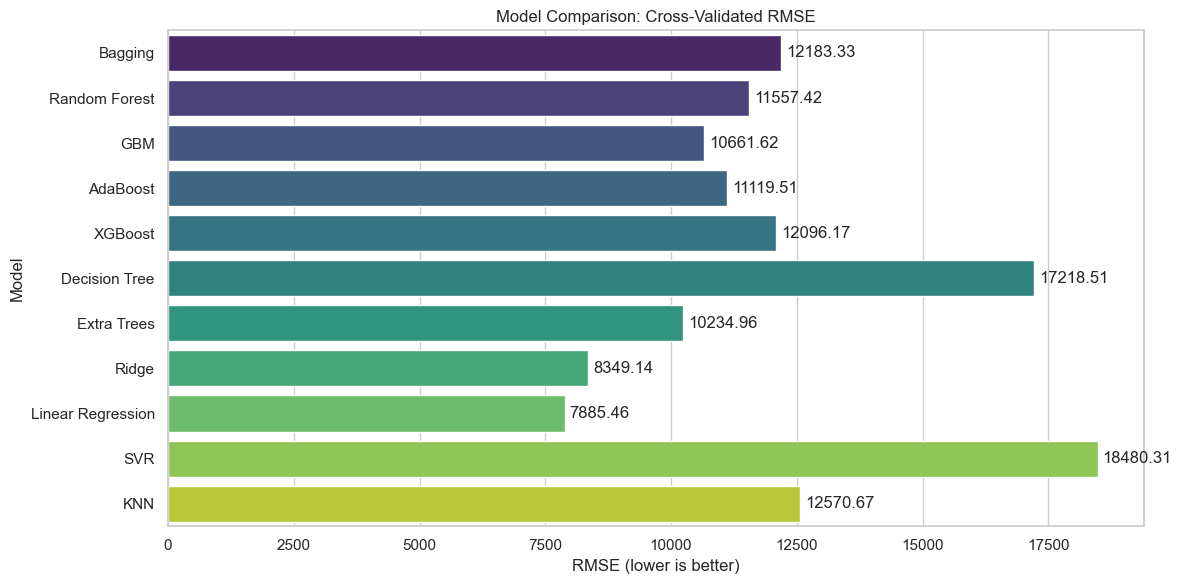

In [1197]:
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.ensemble import (BaggingRegressor, RandomForestRegressor,
                              GradientBoostingRegressor, AdaBoostRegressor,
                              ExtraTreesRegressor)
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler

# Target and features
y = df['Cost(in $)']
x = df.drop(['Cost(in $)', 'S. No.', 'Product_Name','Material'], axis=1)

# # One-hot encoding
# x = pd.get_dummies(x, columns=['Material'], drop_first=True)

# Split the data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.4, random_state=1)

# Models that require scaling
models_needing_scaling = ['Linear Regression', 'Ridge', 'SVR', 'KNN']

# Apply StandardScaler only once
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)  # Fit only on train
x_test_scaled = scaler.transform(x_test)        # Transform test using train's scaler

# Define regression models
models = [
    ("Bagging", BaggingRegressor(random_state=1)),
    ("Random Forest", RandomForestRegressor(random_state=1)),
    ("GBM", GradientBoostingRegressor(random_state=1)),
    ("AdaBoost", AdaBoostRegressor(random_state=1)),
    ("XGBoost", XGBRegressor(random_state=1, eval_metric='rmse')),
    ("Decision Tree", DecisionTreeRegressor(random_state=1)),
    ("Extra Trees", ExtraTreesRegressor(random_state=1)),
    ("Ridge", Ridge(random_state=1)),
    ("Linear Regression", LinearRegression()),
    ("SVR", SVR()),
    ("KNN", KNeighborsRegressor())
]

# Initialize result storage
results = []
names = []
times = []

print('Cross-validation performance (RMSE):\n')

# Cross-validation evaluation
for name, model in models:
    start_time = time.time()
    kfold = KFold(n_splits=10, shuffle=True, random_state=1)
    
    # Choose scaled or unscaled input
    X_input = x_train_scaled if name in models_needing_scaling else x_train
    
    
    # Negative RMSE returned, so take negative of result
    cv_result = cross_val_score(model, X_input, y_train,
                                cv=kfold, scoring='neg_root_mean_squared_error')
    end_time = time.time()

    results.append(cv_result)
    names.append(name)
    times.append(end_time - start_time)

    print(f'{name:<17}: RMSE = {-cv_result.mean():.4f}, Time = {end_time - start_time:.2f} seconds')

# Prepare data for plot
mean_rmses = [-r.mean() for r in results]
rmse_df = pd.DataFrame({'Model': names, 'RMSE': mean_rmses})

# Plotting RMSE with labels
plt.figure(figsize=(12, 6))
sns.set(style="whitegrid")
barplot = sns.barplot(x='RMSE', y='Model', data=rmse_df, palette='viridis')

# Add RMSE value labels to bars
for index, value in enumerate(rmse_df['RMSE']):
    plt.text(value + 100, index, f"{value:.2f}", va='center')

plt.title('Model Comparison: Cross-Validated RMSE')
plt.xlabel('RMSE (lower is better)')
plt.ylabel('Model')
plt.tight_layout()

# Save and display
plt.savefig('C:/Users/sangr/Downloads/INTERN/RMSE_Comparison.jpg', dpi=300)
plt.show()


So, the top 4 performing models are 
- Linear
- Ridge
- Extra Trees

## Model Performance Improvement using Hyperparameter Tuning

In [1200]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd

def regression_performance_evaluation(model, predictors, target):
    pred = model.predict(predictors)

    mae = mean_absolute_error(target, pred)
    mse = mean_squared_error(target, pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(target, pred)

    # Create a dataframe of metrics
    df_perf = pd.DataFrame(
        {
            "MAE": [mae],
            "MSE": [mse],
            "RMSE": [rmse],
            "R² Score": [r2]
        }
    )

    return df_perf


We observe that there is an order-of-magnitude difference(train_RMSE = 11829.352911   and test_RMSE = 125051.348711) between the RMSE on the training data and the test data when using a 75/25 train-test split. Since the dataset contains relatively few data points (around 100), this discrepancy likely indicates overfitting. To mitigate this, I then adjust the split to 60/40 and repeat the same evaluation process to see if it improves the model's generalization. Then i also removed the outliers and did scaling for proper models and then can observe the rmse value dropping  Still there was no improvement SO, I built Linear regression,ridge regression and decision tree regressor and then tune the model by removing insignificant features.

## Extra Trees Regressor

In [1203]:
import time
import numpy as np
import pandas as pd
from scipy.stats import randint
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, make_scorer

# Define RMSE scorer (sklearn expects greater_is_better=True, so we negate RMSE)
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

rmse_scorer = make_scorer(rmse, greater_is_better=False)

# Define the Extra Trees Regressor model
model = ExtraTreesRegressor(random_state=1)

# Define the hyperparameter grid
param_grid = {
    'n_estimators': randint(100, 500),
    'max_depth': randint(3, 10),
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 5),
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False]
}

# Randomized Search CV
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_grid,
    n_iter=25,
    scoring=rmse_scorer,
    cv=5,
    random_state=1,
    verbose=2,
    n_jobs=-1
)

# Fit the model
start_time = time.time()
random_search.fit(x_train, y_train)
print(f"\nRandomizedSearchCV fitting time: {time.time() - start_time:.2f} seconds")

# Best parameters and RMSE
print("Best Parameters:", random_search.best_params_)
print("Best Cross-Validation RMSE:", -random_search.best_score_)  # convert back to positive RMSE

# Retrieve and refit best estimator
ExtraTrees_tuned = random_search.best_estimator_
ExtraTrees_tuned.fit(x_train, y_train)

# Regression evaluation function
from sklearn.metrics import mean_absolute_error, r2_score

def regression_performance_evaluation(model, predictors, target):
    pred = model.predict(predictors)
    mae = mean_absolute_error(target, pred)
    mse = mean_squared_error(target, pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(target, pred)
    return pd.DataFrame({
        "MAE": [mae],
        "MSE": [mse],
        "RMSE": [rmse],
        "R² Score": [r2]
    })

# Evaluate model
print("\nTraining Performance:")
print(regression_performance_evaluation(ExtraTrees_tuned, x_train, y_train))

print("\nValidation Performance:")
print(regression_performance_evaluation(ExtraTrees_tuned, x_test, y_test))


Fitting 5 folds for each of 25 candidates, totalling 125 fits

RandomizedSearchCV fitting time: 145.63 seconds
Best Parameters: {'bootstrap': False, 'max_depth': 8, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 229}
Best Cross-Validation RMSE: 11106.454414800519

Training Performance:
           MAE           MSE         RMSE  R² Score
0  1542.830724  4.092685e+06  2023.038487  0.988128

Validation Performance:
          MAE           MSE         RMSE  R² Score
0  4606.04636  6.613165e+07  8132.136926  0.773388


## Bagging Regressor

In [1205]:
import time
import numpy as np
import pandas as pd
from scipy.stats import randint
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer

# --- Define RMSE Scorer ---
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

rmse_scorer = make_scorer(rmse, greater_is_better=False)

# --- Define the Bagging Regressor Model ---
base_estimator = DecisionTreeRegressor(random_state=1)
model = BaggingRegressor(estimator=base_estimator, random_state=1)


# --- Define the Hyperparameter Grid for Bagging Regressor ---
param_grid = {
    'n_estimators': randint(10, 100),
    'max_samples': [0.5, 0.7, 1.0],
    'max_features': [0.5, 0.7, 1.0],
    'bootstrap': [True, False],
    'bootstrap_features': [True, False]
}

# --- RandomizedSearchCV Setup ---
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_grid,
    n_iter=20,
    scoring=rmse_scorer,
    cv=10,
    random_state=1,
    verbose=2,
    n_jobs=-1
)

# --- Fit the Model and Time It ---
start_time = time.time()
random_search.fit(x_train, y_train)
print(f"\nRandomizedSearchCV fitting time: {time.time() - start_time:.2f} seconds")

# --- Best Parameters and Best RMSE ---
print("Best Parameters:", random_search.best_params_)
print("Best Cross-Validation RMSE:", -random_search.best_score_)

# --- Train Best Estimator ---
bagging_tuned = random_search.best_estimator_
bagging_tuned.fit(x_train, y_train)

# --- Performance Evaluation Function ---
def regression_performance_evaluation(model, predictors, target):
    pred = model.predict(predictors)
    mae = mean_absolute_error(target, pred)
    mse = mean_squared_error(target, pred)
    rmse_val = np.sqrt(mse)
    r2 = r2_score(target, pred)
    return pd.DataFrame({
        "MAE": [mae],
        "MSE": [mse],
        "RMSE": [rmse_val],
        "R² Score": [r2]
    })

# --- Evaluate Performance ---
print("\nTraining Performance:")
print(regression_performance_evaluation(bagging_tuned, x_train, y_train))

print("\nValidation Performance:")
print(regression_performance_evaluation(bagging_tuned, x_test, y_test))


Fitting 10 folds for each of 20 candidates, totalling 200 fits

RandomizedSearchCV fitting time: 45.68 seconds
Best Parameters: {'bootstrap': False, 'bootstrap_features': False, 'max_features': 1.0, 'max_samples': 0.5, 'n_estimators': 42}
Best Cross-Validation RMSE: 12096.70475691334

Training Performance:
           MAE           MSE         RMSE  R² Score
0  4493.020063  3.983836e+07  6311.763747  0.884433

Validation Performance:
           MAE           MSE         RMSE  R² Score
0  5993.261032  9.442849e+07  9717.432293  0.676424


In [1206]:
import time
import numpy as np
import pandas as pd
from sklearn.linear_model import Ridge
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer
from scipy.stats import loguniform

# --- Define RMSE Scorer ---
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

rmse_scorer = make_scorer(rmse, greater_is_better=False)

# --- Define Ridge Regressor ---
ridge_model = Ridge(random_state=1)

# --- Define Hyperparameter Distribution for Ridge ---
param_grid = {
    'alpha': loguniform(1e-4, 1e2)
}

# --- RandomizedSearchCV Setup ---
random_search = RandomizedSearchCV(
    estimator=ridge_model,
    param_distributions=param_grid,
    n_iter=20,
    scoring=rmse_scorer,
    cv=10,
    random_state=1,
    verbose=0,      # Use verbose=0 to avoid WinError on Windows
    n_jobs=-1
)

# --- Fit the Model and Time It ---
start_time = time.time()
random_search.fit(x_train, y_train)
print(f"\nRandomizedSearchCV fitting time: {time.time() - start_time:.2f} seconds")

# --- Best Parameters and Best RMSE ---
print("Best Parameters:", random_search.best_params_)
print("Best Cross-Validation RMSE:", -random_search.best_score_)

# --- Train Best Estimator ---
ridge_tuned = random_search.best_estimator_
ridge_tuned.fit(x_train, y_train)

# --- Performance Evaluation Function ---
def regression_performance_evaluation(model, predictors, target):
    pred = model.predict(predictors)
    mae = mean_absolute_error(target, pred)
    mse = mean_squared_error(target, pred)
    rmse_val = np.sqrt(mse)
    r2 = r2_score(target, pred)
    return pd.DataFrame({
        "MAE": [mae],
        "MSE": [mse],
        "RMSE": [rmse_val],
        "R² Score": [r2]
    })

# --- Evaluate Performance ---
print("\nTraining Performance:")
print(regression_performance_evaluation(ridge_tuned, x_train_scaled, y_train))

print("\nValidation Performance:")
print(regression_performance_evaluation(ridge_tuned, x_test_scaled, y_test))



RandomizedSearchCV fitting time: 17.08 seconds
Best Parameters: {'alpha': 18.565413149854656}
Best Cross-Validation RMSE: 14413.863611733777

Training Performance:
            MAE           MSE          RMSE  R² Score
0  18727.035217  6.782166e+08  26042.592429 -0.967437

Validation Performance:
            MAE           MSE          RMSE  R² Score
0  20500.006136  6.935955e+08  26336.202034 -1.376726


D:\Anaconda\Lib\site-packages\sklearn\linear_model\_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=3.19149e-21): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
D:\Anaconda\Lib\site-packages\sklearn\linear_model\_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=3.19149e-21): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
D:\Anaconda\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  warnings.warn(
D:\Anaconda\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  warnings.warn(


Tuning Linear regression model

## Linear Regressor

In [1209]:
from sklearn.metrics import mean_absolute_error, mean_squared_error,r2_score

def adj_r2_score(predictors,targets,predictions):
    r2 = r2_score(targets, predictions)
    n = predictors.shape[0]
    k = predictors.shape[1]
    return 1 - ((1 - r2) * (n - 1) / (n - k - 1))
# function to compute MAPE
def mape_score(targets, predictions):
    return np.mean(np.abs(targets - predictions) / targets) * 100
    
# function to compute different metrics to check performance of a regression model
def model_performance_regression(model, predictors, target):
    """
    Function to compute different metrics to check regression model performance

    model: regressor
    predictors: independent variables
    target: dependent variable
    """

    # predicting using the independent variables
    pred = model.predict(predictors)

    r2 = r2_score(target, pred)  # to compute R-squared
    adjr2 = adj_r2_score(predictors, target, pred)  # to compute adjusted R-squared
    rmse = np.sqrt(mean_squared_error(target, pred))  # to compute RMSE
    mae = mean_absolute_error(target, pred)  # to compute MAE
    mape = mape_score(target, pred)  # to compute MAPE

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {
            "RMSE": rmse,
            "MAE": mae,
            "R-squared": r2,
            "Adj. R-squared": adjr2,
            "MAPE": mape,
        },
        index=[0],
    )

    return df_perf

In [1210]:
import statsmodels.api as sm

# Add constant to x_train
x_train_const = sm.add_constant(x_train_scaled)

# Fit the model
model = sm.OLS(y_train, x_train_const).fit()

# Summary and coefficients
print(model.summary())
print(model.params)


                            OLS Regression Results                            
Dep. Variable:             Cost(in $)   R-squared:                       0.871
Model:                            OLS   Adj. R-squared:                  0.842
Method:                 Least Squares   F-statistic:                     30.37
Date:                Thu, 22 May 2025   Prob (F-statistic):           8.86e-14
Time:                        18:42:24   Log-Likelihood:                -460.09
No. Observations:                  45   AIC:                             938.2
Df Residuals:                      36   BIC:                             954.4
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.011e+04   1111.606     18.095      0.0

In [1211]:
print('checking model performance on train set.')
x_train_const = sm.add_constant(x_train_scaled)  # during prediction too
model_train = model_performance_regression(model, x_train_const, y_train)

model_train

checking model performance on train set.


,RMSE,MAE,R-squared,Adj. R-squared,MAPE
0,6669.634837,4805.573324,0.870956,0.837774,41.964036


In [1212]:
print('checking model performance on test set.')
x_test_const = sm.add_constant(x_test_scaled)  # during prediction too
model_train = model_performance_regression(model, x_test_const, y_test)
model_test

checking model performance on test set.


,RMSE,MAE,R-squared,Adj. R-squared,MAPE
0,10608.505801,8112.372412,0.614361,0.552658,97.757701


## Testing the assumptions of linear regression model

We will be checking the following Linear Regression assumptions:

1. **No Multicollinearity**

2. **Linearity of variables**

3. **Independence of error terms**

4. **Normality of error terms**

5. **No Heteroscedasticity**

## TEST FOR MULTICOLLINEARITY

In [1216]:
# we will define a function to check VIF
# to compute VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor

def checking_vif(predictors):
    vif = pd.DataFrame()
    vif["feature"] = predictors.columns

    # calculating VIF for each feature
    vif["VIF"] = [
        variance_inflation_factor(predictors.values, i)
        for i in range(len(predictors.columns))
    ]
    return vif
print(checking_vif(x_train))

                        feature       VIF
0                     Lead time  3.783616
1                      Warranty  3.192145
2                        Weight  5.336536
3               Volume(in mm^3)  7.177956
4            working area(mm^2)  2.633232
5                 Cost per mm^3  2.101504
6  Working area to volume ratio  1.618443
7    Average density of machine  2.717004


**Keep**:
  -  Lead time – low VIF, significant
  -   Weight – high VIF, but statistically significant (p = 0.007)
  -   working area(mm^2) – VIF is fine, but p = 0.217 (let's keep it and rebuild the model)

**Remove**:
- Volume(in mm^3) – high VIF + insignificant (p = 0.670)

- Warranty – insignificant (p = 0.546)

- Cost per mm^3 – insignificant (p = 0.305)

- Working area to volume ratio – insignificant (p = 0.305)

- Average density of machine – insignificant (p = 0.305)

Now let's rebuild the model keeping those 3 columns

In [1219]:
# Assuming 'x_train' was the original DataFrame with column names
x_train_scaled_df = pd.DataFrame(x_train_scaled, columns=x_train.columns)
x_test_scaled_df = pd.DataFrame(x_test_scaled, columns=x_test.columns)

# Now select features
selected_features = ['Lead time', 'Weight', 'working area(mm^2)']
x_train2 = x_train_scaled_df[selected_features].reset_index(drop=True)
x_test2 = x_test_scaled_df[selected_features].reset_index(drop=True)

# Reset target index
y_train2 = y_train.reset_index(drop=True)

# Add constant term
x_train2 = sm.add_constant(x_train2)
x_test2 = sm.add_constant(x_test2)

# Fit model
model2 = sm.OLS(y_train2, x_train2).fit()

# Predict
y_pred = model2.predict(x_test2)

# Summary
print(model2.summary())


                            OLS Regression Results                            
Dep. Variable:             Cost(in $)   R-squared:                       0.531
Model:                            OLS   Adj. R-squared:                  0.496
Method:                 Least Squares   F-statistic:                     15.46
Date:                Thu, 22 May 2025   Prob (F-statistic):           7.07e-07
Time:                        18:42:28   Log-Likelihood:                -489.14
No. Observations:                  45   AIC:                             986.3
Df Residuals:                      41   BIC:                             993.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               2.011e+04   1986

In [1220]:

print('checking model performance on train set.')
x_train2 = sm.add_constant(x_train2)
model_train = model_performance_regression(model2,x_train2,y_train)
model_train



checking model performance on train set.


,RMSE,MAE,R-squared,Adj. R-squared,MAPE
0,12717.479029,9684.641152,0.530825,0.483908,178.635912


In [1221]:
print('checking model performance on test set.')
model_test = model_performance_regression(model2,x_test2,y_test)
model_test

checking model performance on test set.


,RMSE,MAE,R-squared,Adj. R-squared,MAPE
0,10608.505801,8112.372412,0.614361,0.552658,66.408769


In [1222]:
def print_equation(y, x_train, model):
    print(f"{y} = ", end="")

    # Loop through the model parameters and corresponding x_train columns
    for i in range(len(x_train.columns)):
        if i == 0:  # Intercept term
            print(model.params[i], "+", end=" ")
        elif i != len(x_train.columns) - 1:  # Intermediate terms
            print(
                f"({model.params[i]})*({x_train.columns[i]}) +", end=" "
            )
        else:  # Last term
            print(f"({model.params[i]})*({x_train.columns[i]})", end="")

    print()  # End the line

print_equation('Cost predicted (in $)',x_train2,model2)

Cost predicted (in $) = 20114.354222222224 + (3133.843864744216)*(Lead time) + (11956.488891366484)*(Weight) + (1541.6482507206501)*(working area(mm^2))


C:\Users\sangr\AppData\Local\Temp\ipykernel_26260\81315783.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(model.params[i], "+", end=" ")
C:\Users\sangr\AppData\Local\Temp\ipykernel_26260\81315783.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  f"({model.params[i]})*({x_train.columns[i]}) +", end=" "
C:\Users\sangr\AppData\Local\Temp\ipykernel_26260\81315783.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f

## TEST FOR LINEARITY AND INDEPENDENCE

**Why the test?**
* Linearity describes a straight-line relationship between two variables, predictor variables must have a linear relation with the dependent variable.

**How to check linearity?**

* Make a plot of fitted values vs residuals. If they don't follow any pattern (the curve is a straight line), then we say the model is linear otherwise model is showing signs of non-linearity.

**How to fix if this assumption is not followed?**

* We can try different transformations.

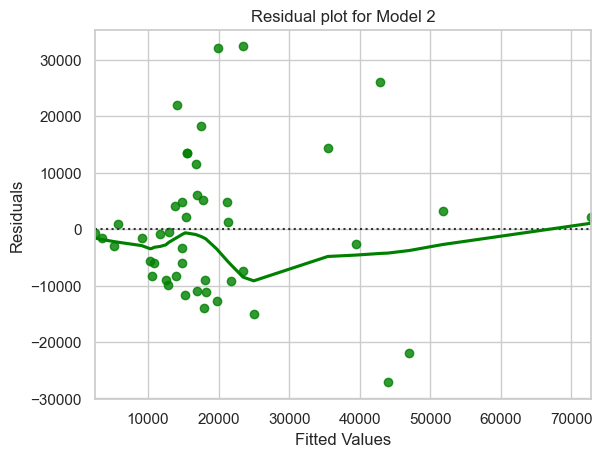

In [1224]:
data_for_test2 = pd.DataFrame({"Actual Values":y_train,"Fitted Values":model2.fittedvalues,"Residuals":model2.resid})
sns.residplot(data_for_test2, x="Fitted Values", y="Residuals", color="green", lowess=True)
plt.title('Residual plot for Model 2')
plt.savefig('C:/Users/sangr/Downloads/INTERN/Residual_plot.jpg')

## TEST FOR NORMALITY

**What is the test?**

* Error terms/residuals should be normally distributed.

* If the error terms are not normally distributed, confidence intervals may become too wide or narrow. Once confidence interval becomes unstable, it leads to difficulty in estimating coefficients based on minimization of least squares.

**What does non-normality indicate?**

* It suggests that there are a few unusual data points which must be studied closely to make a better model.

**How to check the Normality?**

* It can be checked via QQ Plot - residuals following normal distribution will make a straight line plot, otherwise not.

* Another test to check for normality is the Shapiro-Wilk test.

**How to Make residuals normal?**

* We can apply transformations like log, exponential, arcsinh, etc as per our data.

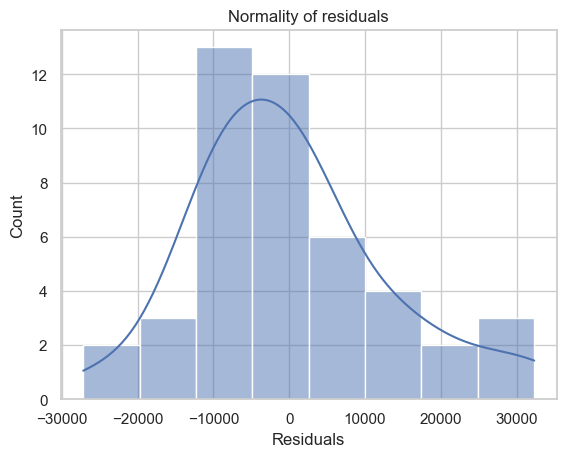

Shpiro Test
ShapiroResult(statistic=nan, pvalue=nan)


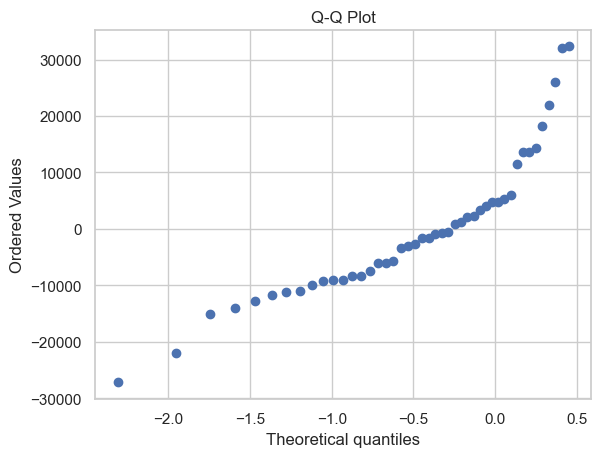

In [1226]:
import pylab
import scipy.stats as stats
sns.histplot(data=data_for_test2, x="Residuals", kde=True)
plt.title("Normality of residuals")
plt.savefig('C:/Users/sangr/Downloads/INTERN/Normality of residuals.jpg')
plt.show()
print('Shpiro Test')
print(stats.shapiro(data_for_test2["Residuals"]))

stats.probplot(data_for_test2["Residuals"], dist="norm", plot=pylab)
plt.title("Q-Q Plot")
plt.savefig('C:/Users/sangr/Downloads/INTERN/Q-Q Plot.jpg')
plt.show()


We can clearly observe that Q-Q plot and residual plot both are not ideal. The reason is mostly because of the dataset is too small.

In [1229]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

# Assuming `df` is your DataFrame
# Apply log transformation to Weight and Volume
df['log_Weight'] = np.log(df['Weight'])
df['log_Volume'] = np.log(df['Volume(in mm^3)'])

# Define the features and target variable
X = df[['log_Weight', 'log_Volume','Lead time','working area(mm^2)']]
y = df['Cost(in $)']

# Add constant term to the predictors
X_const = sm.add_constant(X)

# Fit the OLS model
model_log = sm.OLS(y, X_const).fit()

# Print model summary and coefficients
print(model_log.summary())
print("\nModel Coefficients:\n", model_log.params)


                            OLS Regression Results                            
Dep. Variable:             Cost(in $)   R-squared:                       0.543
Model:                            OLS   Adj. R-squared:                  0.517
Method:                 Least Squares   F-statistic:                     20.78
Date:                Thu, 22 May 2025   Prob (F-statistic):           2.54e-11
Time:                        19:27:31   Log-Likelihood:                -811.93
No. Observations:                  75   AIC:                             1634.
Df Residuals:                      70   BIC:                             1645.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const              -1.005e+05   3.24

Applying log also result in no improvement.